In [1]:
import os
import time
import random
import numpy as np

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
EPOCHS = 35
INIT_LR = 3e-4
BS = 64
IMG_SIZE = 224
NUM_WORKERS = 4
PATIENCE = 7
WEIGHT_DECAY = 1e-4
LABEL_SMOOTHING = 0.1

directory_root = './data'

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

[INFO] Using device: cuda


In [3]:
image_paths = []
label_names = []

try:
    print("[INFO] Scanning image directories ...")
    # Get plant folders, ignoring .DS_Store
    root_dir = [d for d in os.listdir(directory_root) if d != ".DS_Store"]

    for plant_folder in root_dir:
        plant_path = os.path.join(directory_root, plant_folder)
        if not os.path.isdir(plant_path): continue

        # Get disease folders
        disease_folders = [d for d in os.listdir(plant_path) if d != ".DS_Store"]

        for disease_folder in disease_folders:
            disease_path = os.path.join(plant_path, disease_folder)
            if not os.path.isdir(disease_path): continue

            print(f"[INFO] Processing {disease_folder} ...")

            # Get images
            images = [f for f in os.listdir(disease_path) if f != ".DS_Store"]

            for image_file in images:
                file_path = os.path.join(disease_path, image_file)
                # Check extensions
                if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(file_path)
                    label_names.append(disease_folder)

    print(f"[INFO] Found {len(image_paths)} images.")

except Exception as e:
    print(f"Error : {e}")

[INFO] Scanning image directories ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Found 20638 images.


In [4]:
# Create Label Mappings
# Convert string labels (e.g., 'Tomato_Blight') to integers (0, 1, 2...)
unique_labels = sorted(list(set(label_names)))
class_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
n_classes = len(unique_labels)
print(f"[INFO] Classes: {unique_labels}")

# Convert all string labels to integers for the dataset
label_indices = [class_to_idx[name] for name in label_names]

[INFO] Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [5]:
# Split Data: Train / Validation / Test (70 / 15 / 15)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths,
    label_indices,
    test_size=0.30,
    random_state=SEED,
    stratify=label_indices,
 )

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths,
    temp_labels,
    test_size=0.50,
    random_state=SEED,
    stratify=temp_labels,
 )

print(f"[INFO] Train samples: {len(train_paths)}")
print(f"[INFO] Val samples:   {len(val_paths)}")
print(f"[INFO] Test samples:  {len(test_paths)}")

[INFO] Train samples: 14446
[INFO] Val samples:   3096
[INFO] Test samples:  3096


In [6]:
class PlantDataset(Dataset):
    def __init__(self, image_paths, labels, transforms=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image ON DEMAND (Lazy Loading)
        image_path = self.image_paths[idx]

        # Open using PIL (Native RGB support, unlike OpenCV)
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {image_path}: {e}")
            # Return a black image in case of error to prevent crash
            image = Image.new('RGB', (256, 256))

        if self.transforms:
            image = self.transforms(image)

        # Return label as a long tensor (required for CrossEntropyLoss)
        return image, torch.tensor(self.labels[idx], dtype=torch.long)

In [7]:
# Define Transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop((IMG_SIZE, IMG_SIZE), scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

eval_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create Datasets
train_dataset = PlantDataset(train_paths, train_labels, transforms=train_transforms)
val_dataset = PlantDataset(val_paths, val_labels, transforms=eval_transforms)
test_dataset = PlantDataset(test_paths, test_labels, transforms=eval_transforms)

# Faster host->device transfer when CUDA is available
use_pin_memory = device.type == 'cuda'

# Create DataLoaders
train_loader = DataLoader(
    train_dataset, batch_size=BS, shuffle=True, num_workers=NUM_WORKERS, pin_memory=use_pin_memory
)
val_loader = DataLoader(
    val_dataset, batch_size=BS, shuffle=False, num_workers=NUM_WORKERS, pin_memory=use_pin_memory
)
test_loader = DataLoader(
    test_dataset, batch_size=BS, shuffle=False, num_workers=NUM_WORKERS, pin_memory=use_pin_memory
)

In [8]:
# Model Definition
class PlantDiseaseCNN(nn.Module):
    def __init__(self, n_classes):
        super(PlantDiseaseCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.20),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.30),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.35),
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, n_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

In [9]:
model = PlantDiseaseCNN(n_classes).to(device)

In [10]:
# Optimizer and Loss
optimizer = optim.AdamW(model.parameters(), lr=INIT_LR, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

In [11]:
print("[INFO] training network...")

# Lists to store history
history = {'acc': [], 'val_acc': [], 'loss': [], 'val_loss': [], 'lr': []}

# Best model tracking
best_val_loss = float('inf')
epochs_without_improve = 0

for epoch in range(EPOCHS):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_epoch_loss = val_loss / len(val_dataset)
    val_epoch_acc = val_correct / val_total

    # Update scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # Save best model
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        epochs_without_improve = 0
        torch.save({
            'model_state_dict': model.state_dict(),
            'class_to_idx': class_to_idx,
            'img_size': IMG_SIZE
        }, 'best_cnn_model.pth')
        print(f"[INFO] Best model saved with val_loss: {val_epoch_loss:.4f}")
    else:
        epochs_without_improve += 1

    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)
    history['lr'].append(current_lr)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    print(f"Epoch {epoch + 1}/{EPOCHS} - "
          f"loss: {epoch_loss:.4f} - acc: {epoch_acc:.4f} - "
          f"val_loss: {val_epoch_loss:.4f} - val_acc: {val_epoch_acc:.4f} - "
          f"lr: {current_lr:.6f} - time: {int(epoch_mins)}m {int(epoch_secs)}s")

    if epochs_without_improve >= PATIENCE:
        print(f"[INFO] Early stopping at epoch {epoch + 1} (no val_loss improvement in {PATIENCE} epochs)")
        break

[INFO] training network...
[INFO] Best model saved with val_loss: 1.5899
Epoch 1/35 - loss: 1.8662 - acc: 0.4839 - val_loss: 1.5899 - val_acc: 0.5523 - lr: 0.000299 - time: 0m 24s
[INFO] Best model saved with val_loss: 1.4198
Epoch 2/35 - loss: 1.4929 - acc: 0.6274 - val_loss: 1.4198 - val_acc: 0.6214 - lr: 0.000298 - time: 0m 24s
[INFO] Best model saved with val_loss: 1.2848
Epoch 3/35 - loss: 1.3505 - acc: 0.6893 - val_loss: 1.2848 - val_acc: 0.7032 - lr: 0.000295 - time: 0m 22s
[INFO] Best model saved with val_loss: 1.1057
Epoch 4/35 - loss: 1.2462 - acc: 0.7397 - val_loss: 1.1057 - val_acc: 0.7917 - lr: 0.000290 - time: 0m 22s
[INFO] Best model saved with val_loss: 0.9947
Epoch 5/35 - loss: 1.1687 - acc: 0.7762 - val_loss: 0.9947 - val_acc: 0.8492 - lr: 0.000285 - time: 0m 22s
[INFO] Best model saved with val_loss: 0.9811
Epoch 6/35 - loss: 1.1050 - acc: 0.8032 - val_loss: 0.9811 - val_acc: 0.8475 - lr: 0.000279 - time: 0m 24s
[INFO] Best model saved with val_loss: 0.9686
Epoch 7/3

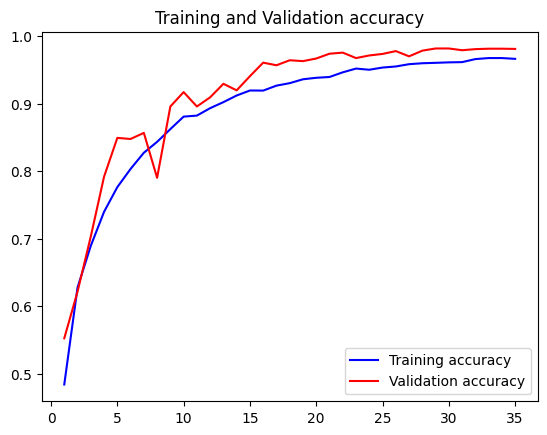

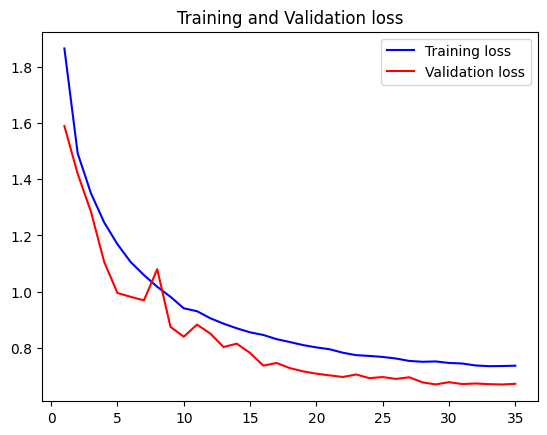

In [12]:
acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs_range, acc, 'b', label='Training accuracy')
plt.plot(epochs_range, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

plt.figure()
# Train and validation loss
plt.plot(epochs_range, loss, 'b', label='Training loss')
plt.plot(epochs_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [13]:
# Load best model for final evaluation on untouched test set
print("[INFO] Loading best model for final evaluation...")
checkpoint = torch.load('best_cnn_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {(correct / total) * 100:.2f}%")

[INFO] Loading best model for final evaluation...
Test Accuracy: 98.61%
